In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from glob import glob
import seaborn as sns

import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import random
from termcolor import colored
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

In [2]:
def readImage_rgb(img_path):
    '''OpenCV loads color images in BGR mode and converts to RGB mode for visualization;
       output: (H x W x n_channel)'''
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb



In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classes = ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
tissue_types = [i.split('_')[1] for i in classes]
print(tissue_types)

['TUMOR', 'STROMA', 'COMPLEX', 'LYMPHO', 'DEBRIS', 'MUCOSA', 'ADIPOSE', 'EMPTY']


In [3]:
inception_fc2 = models.inception_v3(pretrained=True)
inception_fc2.fc = nn.Sequential(nn.Linear(inception_fc2.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 8))
inception_fc2.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 8))
inception_fc2.to(device)  # Move the model to the GPU

if device.type == 'cpu':
    state_dict = torch.load('/notebooks/Colorectal_histology_inception_epoch50_lr4_fc2.pth', map_location='cpu')
else:
    state_dict = torch.load('/notebooks/Colorectal_histology_inception_epoch50_lr4_fc2.pth')
inception_fc2.load_state_dict(state_dict)
inception_fc2.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [11]:
def histology_cls2(img_path, resolution, model, tissue_types, device):
    model.to(device)
    img = readImage_rgb(img_path)
    
    img_transforms = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    dt = np.dtype(int)
    pred_label = np.array([], dtype = dt)
    top_prob_array = np.array([])
    probs_array = np.array(tissue_types).reshape(1,-1)
    
    for i in np.arange(75, 5000-75, resolution):
        for j in np.arange(75, 5000-75, resolution):
            loc = (j,i)
            img_crop = img[loc[0]-75:loc[0]+75,loc[1]-75:loc[1]+75,:] 
            img_pil = Image.fromarray(img_crop.astype('uint8'), 'RGB')
            input_img = torch.unsqueeze(img_transforms(img_pil).to(device), dim=0)
            with torch.no_grad():
                model.eval()
                output = model(input_img)
                softmax = nn.Softmax(dim=1)
                output_softmax = softmax(output)
                top_prob, pred = output_softmax.topk(1,dim=1)
                top_prob, pred = top_prob.cpu().item(), pred.cpu().item()
                probs = output_softmax.cpu()
                pred_label = np.append(pred_label, pred)
                top_prob_array = np.append(top_prob_array, top_prob)
                probs_array = np.concatenate((probs_array, probs))
    pred_df = pd.DataFrame({'pred': pred_label, 'prob': top_prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    return pred_df, probs_df

In [12]:
img_paths = glob('/notebooks/Kather_texture_2016_larger_images_10/*')

In [14]:
print(img_paths[0])

/notebooks/Kather_texture_2016_larger_images_10/CRC-Prim-HE-02-APPLICATION.tif


In [12]:
pred_df.to_csv('/notebooks/img0_50px_preds_df_small_cnn_test.csv', index=False)

In [14]:
probs_df.to_csv('/notebooks/img0_50px_prob_df_small_cnn_test.csv', index = False)

In [19]:
pred_df.to_csv('/notebooks/tileimg_50px_pred_df.csv', index = False)
probs_df.to_csv('/notebooks/tileimg_50px_probs_df.csv', index = False)

In [11]:
import math

data_size = np.array(pred_df).size
side_length = int(math.sqrt(data_size))



In [20]:
pred_df.to_csv('/notebooks/img6_50px_pred_df.csv', index = False)
probs_df.to_csv('/notebooks/img6_50px_probs_df.csv', index = False)

## At 25 Pixel Resolution

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import ListedColormap

def plot_prediction_with_transformations(img_path, pred_dfs):
    palette = sns.color_palette('hls', 8)
    cmap = ListedColormap(palette)
    img = Image.open(img_path)  # Load the image using PIL
    fig = plt.figure(figsize=(12, 6))  # Adjust the figure size for both subplots
    gs = GridSpec(1, 2, width_ratios=[1, 1])  # Equal width ratios

    # Display the original image
    ax = fig.add_subplot(gs[0])
    plt.imshow(img)
    ax.set_title('Original Image', fontsize=18)

    # Display the heatmap and colorbar
    pred_path = pred_dfs[0]  # Use the data for 5px resolution
    pred_df = pd.read_csv(pred_path)
    preds = pred_df['pred']
    side_length = int(np.sqrt(len(preds)))  # Calculate side_length based on preds
    ax = fig.add_subplot(gs[1])
    ax.set_title('5px', fontsize=18)
    heatmap = plt.imshow(np.array(preds).reshape(side_length, side_length), cmap=cmap)

    # Add colorbar with class labels
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.ax.get_yaxis().set_ticks([])
    for i, v in enumerate(classes):
        cbar.ax.text(1.5, (7 * i + 3) / 8.0, v, ha='center', va='center')

    # Apply transformations to the heatmap
    # Flip the prediction image horizontally by 180 degrees
    flipped_heatmap = np.flip(heatmap.get_array(), axis=1)

    # Rotate the flipped image to the left by 90 degrees
    rotated_heatmap = np.rot90(flipped_heatmap, k=1)

    # Update the heatmap with the transformed image
    heatmap.set_data(rotated_heatmap)

    plt.show()

# Usage
pred_dfs = ['/notebooks/img5_50px_pred_df_par.csv']
plot_prediction_with_transformations(img_paths[5], pred_dfs)


## At 50 Pixels Resolution

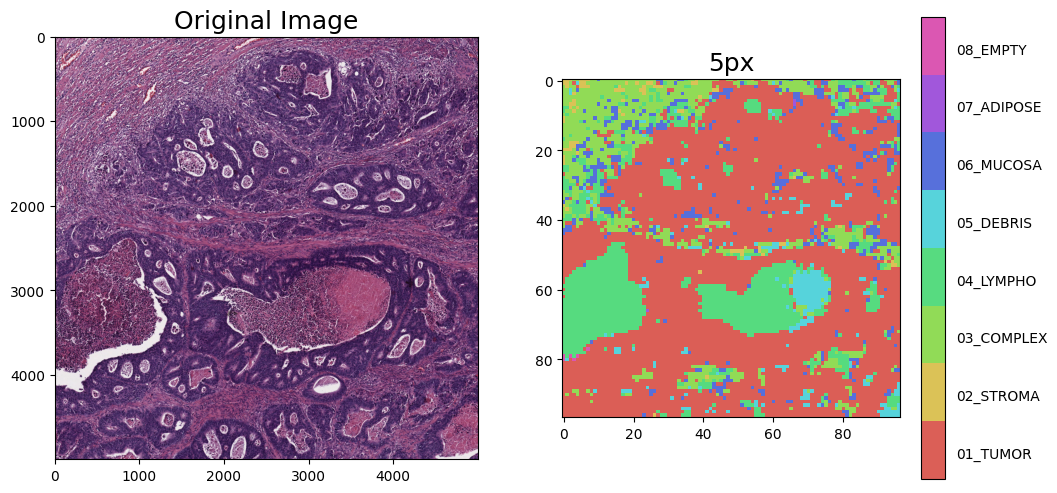

In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import ListedColormap

def plot_prediction_with_transformations(img_path, pred_dfs):
    palette = sns.color_palette('hls', 8)
    cmap = ListedColormap(palette)
    img = Image.open(img_path)  # Load the image using PIL
    fig = plt.figure(figsize=(12, 6))  # Adjust the figure size for both subplots
    gs = GridSpec(1, 2, width_ratios=[1, 1])  # Equal width ratios

    # Display the original image
    ax = fig.add_subplot(gs[0])
    plt.imshow(img)
    ax.set_title('Original Image', fontsize=18)

    # Display the heatmap and colorbar
    pred_path = pred_dfs[0]  # Use the data for 5px resolution
    pred_df = pd.read_csv(pred_path)
    preds = pred_df['pred']
    side_length = int(np.sqrt(len(preds)))  # Calculate side_length based on preds
    ax = fig.add_subplot(gs[1])
    ax.set_title('5px', fontsize=18)
    heatmap = plt.imshow(np.array(preds).reshape(side_length, side_length), cmap=cmap)

    # Add colorbar with class labels
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.ax.get_yaxis().set_ticks([])
    for i, v in enumerate(classes):
        cbar.ax.text(1.5, (7 * i + 3) / 8.0, v, ha='left', va='center')

    # Apply transformations to the heatmap
    # Flip the prediction image horizontally by 180 degrees
    flipped_heatmap = np.flip(heatmap.get_array(), axis=1)

    # Rotate the flipped image to the left by 90 degrees
    rotated_heatmap = np.rot90(flipped_heatmap, k=1)

    # Update the heatmap with the transformed image
    heatmap.set_data(rotated_heatmap)

    plt.show()

# Usage
pred_dfs = ['/notebooks/parallel_process_output/CRC-Prim-HE-02-APPLICATION_pred_df.csv']
plot_prediction_with_transformations(img_paths[0], pred_dfs)


## Proper sizes of plot 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns

def plot_prob(img_path, pred_path, prob_path, resolution, tissue):
    resolution_dict = {'5px': 970, '10px': 485, '50px': 97}
    palette = sns.color_palette('hls', 8)
    cmap = ListedColormap(palette)
    img = readImage_rgb(img_path)
    fig = plt.figure(figsize=(30, 10))
    gs = GridSpec(1, 6, width_ratios=[6, 6, 6, 1, 1, 1], wspace=0.2)
    ax = fig.add_subplot(gs[0])
    plt.imshow(img)
    ax.set_title('raw image', fontsize=18)

    img_size = resolution_dict[resolution]
    pred_df = pd.read_csv(pred_path)
    preds = pred_df['pred']
    
    ax = fig.add_subplot(gs[1])
    ax.set_title('pred_{}'.format(resolution), fontsize=18)
    
    # Apply transformations to the prediction heatmap
    rotated_preds = np.fliplr(np.array(preds).reshape(img_size, img_size))  # Flip horizontally
    rotated_preds = np.rot90(rotated_preds, k=1)  # Rotate to the left by 90 degrees
    heatmap = plt.imshow(rotated_preds, cmap=cmap)

    ax = fig.add_subplot(gs[2])
    ax.set_title('prob for {}'.format(tissue), fontsize=18)
    prob_df = pd.read_csv(prob_path)
    probs = prob_df[tissue]
    rotated_probs = np.fliplr(np.array(probs).reshape(img_size, img_size))  # Flip horizontally
    rotated_probs = np.rot90(rotated_probs, k=1)  # Rotate to the left by 90 degrees
    heatmap2 = plt.imshow(rotated_probs, cmap='hot')

    # Create a separate subplot for the legend
    legend_ax = fig.add_subplot(gs[3])
    legend_ax.axis('off')
    cbar = plt.colorbar(heatmap, cax=legend_ax)
    cbar.ax.get_yaxis().set_ticks([])
    
    # Display text in its respective color
    for i, v in enumerate(classes):
        cbar.ax.text(1.5, (7 * i + 2.8) / 8.0, v, color=cmap(i / 7), ha='left', va='center')  # Use cmap(i / 7) to get the respective color

    ax = fig.add_subplot(gs[4], xticks=[], yticks=[])
    ax.axis('off')

    plt.show()

# You'll need to define or import the missing functions and variables like `readImage_rgb` and `classes`.


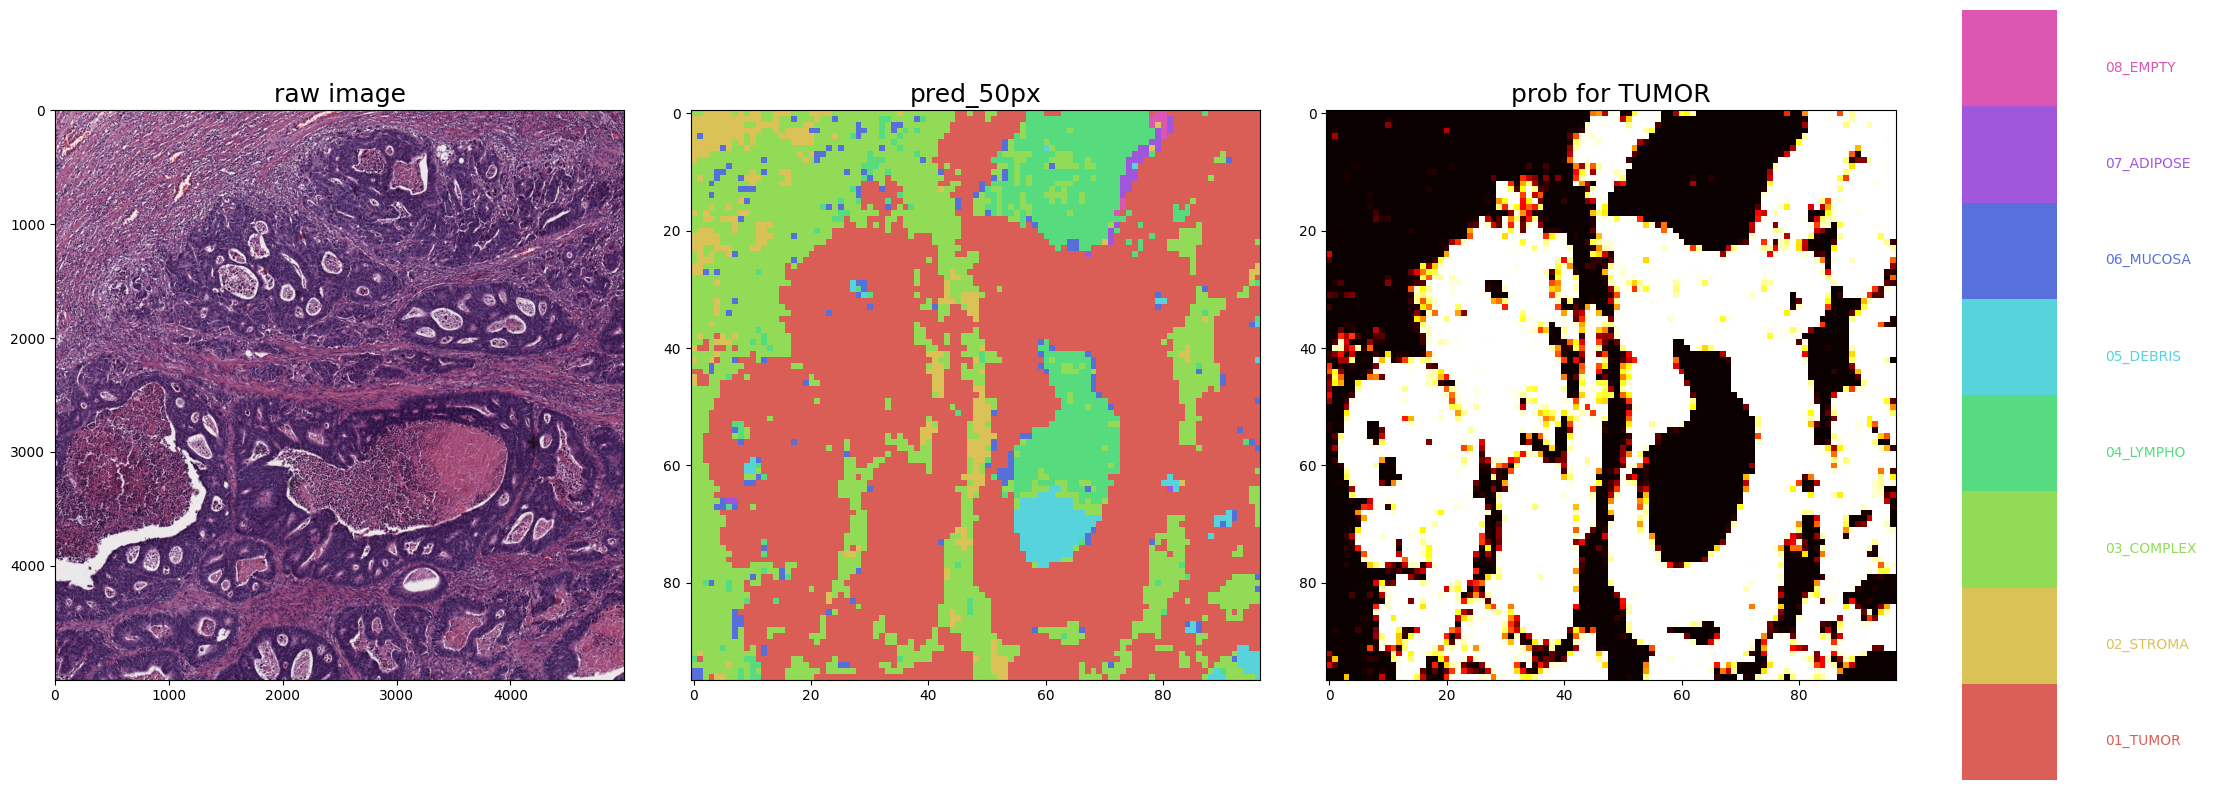

In [19]:
pred_df_path = '/notebooks/img0_50px_preds_df_small_cnn_test.csv'
prob_df_path = '/notebooks/img0_50px_prob_df_small_cnn_test.csv'
plot_prob(img_path=img_paths[0],  pred_path = pred_df_path, prob_path=prob_df_path, resolution='50px', tissue='TUMOR')

## Parallel Processing code